In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# Download Intel data from Yahoo Finance
intc_data = yf.download("INTC", start="2005-01-01", end="2024-11-26", interval="1wk")

intc_data.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,INTC,INTC,INTC,INTC,INTC
Date,,,,,
2024-10-26,23.200001,23.580000,21.469999,22.670000,462235000
2024-11-02,26.200001,26.430000,22.000000,22.959999,438447400
2024-11-09,24.350000,26.290001,23.889999,25.959999,305284000
2024-11-16,24.500000,25.020000,23.549999,24.330000,266762800
2024-11-23,24.049999,25.570000,23.809999,25.040001,160742000


ADF Statistic for prices: -1.481474
p-value for prices: 0.542655
ADF Statistic for returns: -32.756717
p-value for returns: 0.000000


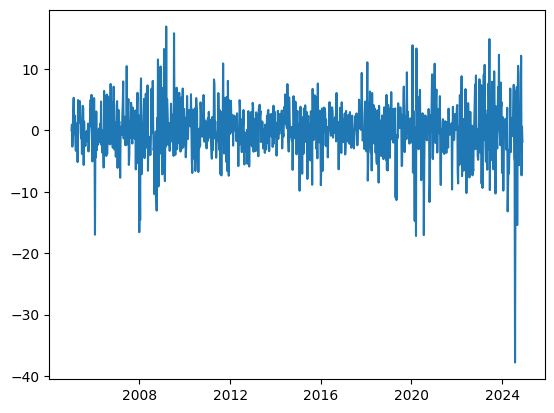

In [3]:
# Use 'Adj Close' if available; otherwise, fall back to 'Close'
if 'Adj Close' in intc_data.columns:
    price_series = intc_data['Adj Close']
else:
    price_series = intc_data['Close']

price_series = price_series.dropna()

# apply ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(price_series)
print('ADF Statistic for prices: %f' % result[0])
print('p-value for prices: %f' % result[1])

# Compute log returns
#first_val = np.log(price_series.iloc[0])
returns = 100*np.log(price_series).diff().fillna(0)
#returns = np.diff(np.log(price_series), prepend=first_val[0], axis=0)

plt.plot(returns)

result = adfuller(returns)
print('ADF Statistic for returns: %f' % result[0])
print('p-value for returns: %f' % result[1])

In [6]:
# Define grids for model parameters
mean_models = ['Constant', 'AR']
vol_models = ['GARCH', 'EGARCH']
dists = ['normal', 't']

results = []

for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            print(f"Fitting model with mean: {mean}, vol: {vol}, dist: {dist}")
            lags = 1 if mean == 'AR' else 0
            
            # -----------------------------
            # Fit the full model on the complete dataset
            model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
            res = model.fit(disp='off')
            # Extract the conditional volatility values
            cond_vol = res.conditional_volatility

            # -----------------------------
            # Get the AIC from the model
            aic = res.aic
            results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})
            print(f"AIC: {aic}")

Fitting model with mean: Constant, vol: GARCH, dist: normal
AIC: 5895.705416515602
Fitting model with mean: Constant, vol: GARCH, dist: t
AIC: 5811.8583859072905
Fitting model with mean: Constant, vol: EGARCH, dist: normal
AIC: 5898.988552186813
Fitting model with mean: Constant, vol: EGARCH, dist: t
AIC: 5812.548159825795
Fitting model with mean: AR, vol: GARCH, dist: normal
AIC: 5893.707028750765
Fitting model with mean: AR, vol: GARCH, dist: t
AIC: 5809.747410221198
Fitting model with mean: AR, vol: EGARCH, dist: normal
AIC: 5897.103932087711
Fitting model with mean: AR, vol: EGARCH, dist: t
AIC: 5810.7285987679525


In [8]:
model_best = arch_model(returns, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='t')
res_best = model_best.fit(disp='off')
print(res_best.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                         INTC   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -2898.87
Distribution:      Standardized Student's t   AIC:                           5809.75
Method:                  Maximum Likelihood   BIC:                           5839.42
                                              No. Observations:                 1038
Date:                      Thu, Feb 06 2025   Df Residuals:                     1036
Time:                              18:08:58   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

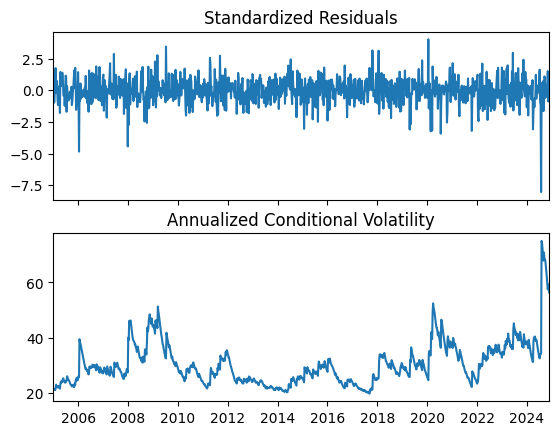

In [9]:
res_best.plot(annualize='W')
plt.show()

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([ 0.00753576,  0.0061346 ,  0.00896559,  0.00954947,  0.00847427,
         0.0082883 ,  0.00654009,  0.00588711,  0.00607195,  0.00792675,
         0.00915169,  0.00924734,  0.01051115,  0.01429154,  0.01662624,
         0.01957635,  0.014976  ,  0.01945638,  0.01723869,  0.01565396,
         0.01033738, -0.00610319, -0.00853625, -0.00532043, -0.01014318,
        -0.01284334, -0.01137364, -0.00894608, -0.01099497, -0.00692431,
        -0.00872551, -0.01233412, -0.00727393, -0.0021898 , -0.00655613,
        -0.00760512, -0.00997762, -0.00694898,  0.00385402,  0.00524863,
         0.0053464 ]),
 <matplotlib.lines.Line2D at 0x7d56ed9c6450>)

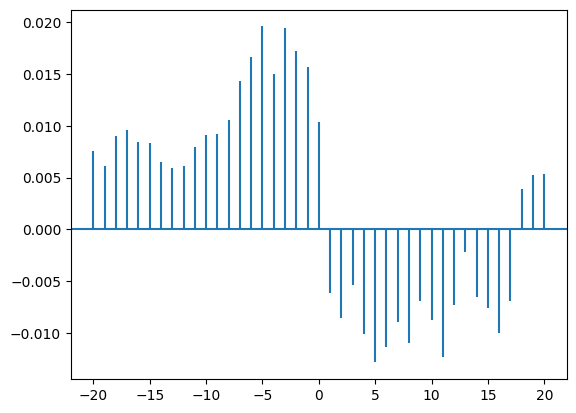

In [10]:
cond_vol = np.array(res_best.conditional_volatility)[1:]
ret_arr = np.array(returns).flatten()[1:]


# plot cross-correlation function between residuals and volatility
plt.xcorr(cond_vol, ret_arr, maxlags=20)

[54.38175991 54.08442886 53.77845883 53.47634573 53.17805849]


<Axes: >

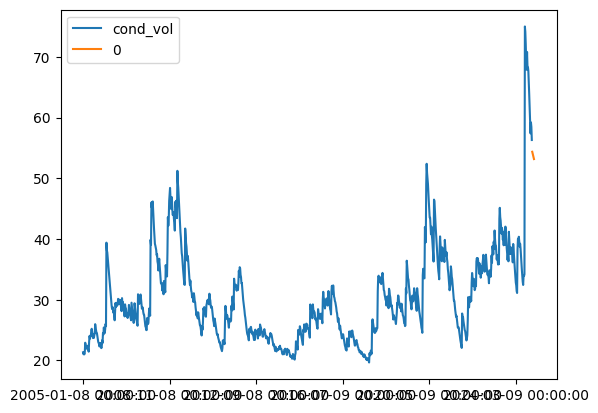

In [11]:
forecast = res_best.forecast(horizon=5, reindex=False)

annualizer = 52

cond_var = res_best.conditional_volatility[1:]
forecast_var = np.sqrt(forecast.variance.values[-1, :])
forecast_var = forecast_var * np.sqrt(annualizer)
print(forecast_var)
pd.concat((cond_var*np.sqrt(annualizer), pd.Series(forecast_var)), axis=1).plot()

In [12]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Prices a European call or put option using the Black-Scholes formula.
    
    Parameters:
    S : float : Current stock price
    K : float : Strike price
    T : float : Time to expiration (in years)
    r : float : Risk-free interest rate (annualized)
    sigma : float : Volatility of the underlying asset (annualized)
    option_type : str : "call" for call option, "put" for put option
    
    Returns:
    float : Option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    
    return price

In [16]:
# 5 step forecast
annualizer = 52
S = price_series["INTC"].iloc[-1]    # Current stock price
K = S    # Strike price
T = 1/52      # Time to expiration (in years)
r = 0.05   # Risk-free interest rate (5%)
sigma = np.sqrt(forecast.variance.values[-1,:])[0]*np.sqrt(annualizer)  # Annualized volatility forecast

call_price = black_scholes(S, 24.07, T, r, sigma, option_type="call")
put_price = black_scholes(S, 24.02, T, r, sigma, option_type="put")

print(f"Current Stock Price: {S}")
print(f"1 Week European Call Option Price: {call_price:.4f}")
print(f"1 Week European Put Option Price: {put_price:.4f}")

call_prem = 24.044
put_prem = 23.9912

call_profit = call_price - call_prem
put_profit = put_price - put_prem

Current Stock Price: 24.049999237060547
1 Week European Call Option Price: 24.0461
1 Week European Put Option Price: 23.9930


In [17]:
print(f"Call Option Profit: {call_profit:.4f}")
print(f"Put Option Profit: {put_profit:.4f}")

Call Option Profit: 0.0021
Put Option Profit: 0.0018
